In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

import nltk; nltk.download('stopwords')

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models 
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/huiwen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(["palestinianlivesmatter",
                 "israelterrorist""israelterrorists","save_sheikh_jarrah"])

In [5]:
# Read data
df = pd.read_csv('/Users/huiwen/Documents/Side Projects/Omdena/omdena-colombia-socialnetwork/Untitled/src/data/task-2-preprocessing/merged_data/Final/Final_all.csv')
df.head()

,Unnamed: 0,created_at,id_str,conversation_id_str,full_text,twitter_lang,favorited,retweeted,retweet_count,favorite_count,...,preprocessed_data,emoji_list,emoticons_list,filename,preprocessed_data_without_hashtags,data_source,lang,score,langTb,lang_langdetect
0,0,2021-03-27T04:09:42+00:00,1.375661e+18,1.375265e+18,@Diputado_Canelo Hagamos otro por el uno de ma...,es,False,False,0.0,1.0,...,"['hacer', 'mayo', 'cazar', 'fantasma', 'mayo']",[''],[':/'],Mayo_SPANISH_tweets_stweet.csv,"['hacer', 'mayo', 'cazar', 'fantasma']",Twitter,es,NaN,NaN,NaN
1,1,2021-03-22T21:12:09+00:00,1.374107e+18,1.374107e+18,Después de esperar con ancias el #28F ahora es...,es,False,False,1.0,4.0,...,"['despues', 'esperar', 'ancia', 'ahora', 'espe...",['💙🤍💙'],[],Mayo_SPANISH_tweets_stweet.csv,"['despues', 'esperar', 'ancia', 'ahora', 'espe...",Twitter,es,NaN,NaN,NaN
2,2,2021-03-22T12:30:53+00:00,1.373975e+18,1.373975e+18,Espero que ésto llegue hasta oídos de la nueva...,es,False,False,0.0,1.0,...,"['esperar', 'llegar', 'oido', 'nuevo', 'inicia...",[''],[],Mayo_SPANISH_tweets_stweet.csv,"['esperar', 'llegar', 'oido', 'nuevo', 'inicia...",Twitter,es,NaN,NaN,NaN
3,3,2021-04-04T12:56:55+00:00,1.378693e+18,1.378693e+18,A menos de un mes del #1Mayo Urkullu teme perd...,es,False,False,3.0,5.0,...,"['menos', 'mes', 'mayo', 'urkullu', 'temer', '...",[''],[],Mayo_SPANISH_tweets_stweet.csv,"['menos', 'mes', 'urkullu', 'temer', 'perder',...",Twitter,es,NaN,NaN,NaN
4,4,2021-04-03T20:14:57+00:00,1.378441e+18,1.378441e+18,La X Edición del Festival Internacional Un Pue...,es,False,False,1.0,3.0,...,"['edicion', 'festival', 'internacional', 'puen...",[''],"[':/', ':/']",Mayo_SPANISH_tweets_stweet.csv,"['edicion', 'festival', 'internacional', 'puen...",Twitter,es,NaN,NaN,NaN


In [10]:
# processed list of words to str
df['preprocessed_str_without_hashtags'] = df['preprocessed_data_without_hashtags'].apply(eval).apply(' '.join)
# df.head()

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
#         print(sentence)

data = df.preprocessed_str_without_hashtags.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:2])

[['hacer', 'mayo', 'cazar', 'fantasma'], ['despues', 'esperar', 'ancia', 'ahora', 'esperar', 'despues', 'ser', 'inmagino', 'celebracion', 'ano', 'independencia', 'patria', 'ahora', 'si', 'jubil', 'ser', 'verdadero', 'libertad']]


### Bigram and Trigram Models

In [12]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [13]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [14]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, verb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:2])

[[], ['despue', 'despue', 'ser', 'celebracion', 'verdadero']]


### Date Transformation -  Corpus for needed for Topic Modelling

In [15]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:2])

[[], [(0, 1), (1, 2), (2, 1), (3, 1)]]


In [16]:
id2word[0]
# corpus[:1][0][:10]

'celebracion'

In [18]:
# Readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:3]]

[[],
 [('celebracion', 1), ('despue', 2), ('ser', 1), ('verdadero', 1)],
 [('dinero', 1),
  ('iniciar', 1),
  ('joven', 1),
  ('laboral', 1),
  ('ojalar', 1),
  ('partir', 1),
  ('programa', 1),
  ('proximo', 1),
  ('ver', 1)]]

### Building Topic Model

In [19]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [20]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.061*"video" + 0.050*"social" + 0.050*"show" + 0.044*"talk" + '
  '0.037*"issue" + 0.032*"idea" + 0.031*"explain" + 0.028*"link" + '
  '0.020*"else" + 0.012*"earn"'),
 (1,
  '0.109*"kill" + 0.081*"much" + 0.047*"duque" + 0.047*"problem" + '
  '0.045*"work" + 0.044*"economic" + 0.031*"pandemic" + 0.024*"account" + '
  '0.023*"enough" + 0.022*"care"'),
 (2,
  '0.200*"live" + 0.060*"cartel" + 0.045*"por_favor" + 0.035*"rural" + '
  '0.022*"pm" + 0.022*"available" + 0.022*"internet" + 0.018*"central" + '
  '0.015*"version" + 0.010*"initiative"'),
 (3,
  '0.068*"go" + 0.064*"colombian" + 0.059*"tax" + 0.050*"say" + 0.046*"make" + '
  '0.040*"even" + 0.037*"pay" + 0.036*"many" + 0.019*"year" + 0.015*"high"'),
 (4,
  '0.281*"country" + 0.034*"number" + 0.034*"loan" + 0.028*"cost" + '
  '0.026*"current" + 0.023*"credit_score" + 0.020*"basically" + 0.017*"borrow" '
  '+ 0.017*"currency" + 0.016*"buy"'),
 (5,
  '0.043*"people" + 0.026*"government" + 0.017*"police" + 0.017*"protest" + '


### Compute Model Perplexity and Coherance Score

In [21]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is, lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -11.096522705382885

Coherence Score:  0.5226446831270507


### Visualise Topic Keywords

In [22]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.396828 -0.189081       1        1  37.448101
3     -0.134757  0.249849       2        1  12.403859
6     -0.032036  0.144299       3        1  10.600392
9      0.015374  0.071669       4        1   9.001634
8      0.058157  0.139152       5        1   7.889373
0      0.067858 -0.001446       6        1   7.137130
1      0.022918 -0.113600       7        1   6.597279
4      0.114246  0.012490       8        1   3.904907
2      0.142373 -0.155963       9        1   2.657987
7      0.142694 -0.157369      10        1   2.359339, topic_info=           Term         Freq        Total Category  logprob  loglift
1555    country  1185.000000  1185.000000  Default  30.0000  30.0000
2780       kill   779.000000   779.000000  Default  29.0000  29.0000
1225       live   574.000000   574.000000  Default  28.0000  28.0000
828          go   916.000000   916.000000  Default  27.0000  27.0000
1444        new   479.000000   479.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
7769     scream     7.347922    13.538406  Topic10  -5.8502   3.1357
9055       hunt     4.253359     6.441734  Topic10  -6.3969   3.3317
9302   investor     4.037385     7.900751  Topic10  -6.4490   3.0754
11802    either     4.402790    23.170586  Topic10  -6.3624   2.0861
8276       user     3.775620    26.827858  Topic10  -6.5161   1.7859

[430 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
82       10  0.918826   accion
2571      7  0.995368  account
8885      1  0.006129      act
8885      3  0.986796      act
913       7  0.987067    actor
...     ...       ...      ...
8588      1  0.010845    woman
8588      3  0.986882    woman
7150      7  0.996977     work
6996      2  0.999051     year
2160      5  0.984690  youtube

[686 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 4, 7, 10, 9, 1, 2, 5, 3, 8])

### Building LDA Mallet Model

In [23]:
# !curl http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip — output mallet-2.0.8.zip
# !unzip mallet-2.0.8.zip

In [24]:
## Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/Users/huiwen/Downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word) # latest gensim not supported, use 3.8.3

Mallet LDA: 10 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 473
total tokens: 100560
<10> LL/token: -10.05697
<20> LL/token: -9.68433
<30> LL/token: -9.47571
<40> LL/token: -9.35579

0	5	poder ser ir gobierno mejor querer dinero existir hacer creer sector fuerza necesitar trabajo politico meno movilizacion persona entonce eleccion 
1	5	protest shoot stop video murder social criminal attack civilian duque continue day show fight find end economic group fuck leave 
2	5	ver gente querer todo problema matar paro persona vivir ir ciudad pue please_help petro politico tocar pensar estar solo partido 
3	5	police colombian kill protester live world happen real today call year president crisis read situation give change abuse point pandemic 
4	5	hacer hablar ver parte entender si social paro estar ir poco igual talk lider gobierno poder por vario uribismo directo 
5	5	estar dar colombio vida vivo dictadura favor total trabajar ayuda millon poner acabar share trave asesino corr

<310> LL/token: -9.00981
<320> LL/token: -9.00476
<330> LL/token: -9.00158
<340> LL/token: -9.00046

0	5	poder ser mejor politico persona hacer pensar entonce ir dinero venir deber existir sector creer partido tener buscar pagar eleccion 
1	5	protest police video colombian shoot violence murder stop attack civilian continue show force city fight young man street talk end 
2	5	ver querer ir gente solo dejar problema persona vivir situacion igual ciudad pue tocar volver acabar terminar destruir peor meno 
3	5	people kill government colombian protester police day state happen world today call president year colombia month live find read share 
4	5	hacer hablar si parte necesitar trabajar gracia entender todo responder calle siempre uribismo trabajo parecer salir sentir servir robar por_favor 
5	5	vida colombio duque todo dar matar calle dictadura favor presidente poner defender muerte exigir asesino ayuda trave accion responsable ocurrir 
6	5	social civil duque idea post narco lider total

<610> LL/token: -8.98024
<620> LL/token: -8.97488
<630> LL/token: -8.97552
<640> LL/token: -8.98382

0	5	poder ser mejor politico persona pensar dinero partido deber existir sector entonce tener actual ir llevar eleccion buscar tema creer 
1	5	police colombian protest amp protester violence shoot stop attack civilian murder show continue force colombia city fight young man abuse 
2	5	ver querer ir solo gente persona acabar dejar igual problema volver si tocar pue terminar destruir poner peor meno creer 
3	5	people government kill happen day live protest state world today call president month find read share citizen talk power real 
4	5	hacer todo hablar parte si necesitar gracia poder trabajar entender responder trabajo fuerza siempre mismo parecer salir sentir poco servir 
5	5	vida colombio calle dar duque favor video matar dictadura defender presidente asesino ayuda trave ocurrir derecho muerte responsable todo directo 
6	5	social duque civil idea narco post situacion sacar lider esp

<910> LL/token: -8.98453
<920> LL/token: -8.98264
<930> LL/token: -8.97012
<940> LL/token: -8.97313

0	5	ser poder persona mejor politico pensar dinero partido deber existir sector post quedar actual creer parecer eleccion buscar tema pagar 
1	5	police colombian protest amp protester violence shoot stop attack civilian continue colombia force video city month fight young man abuse 
2	5	ver ir querer solo gente acabar dejar problema volver igual pue tocar si poner destruir meno terminar petro uribismo peor 
3	5	people government kill protest happen day live state world today show call president find read share talk power citizen order 
4	5	hacer poder hablar parte entonce si necesitar trabajar gracia entender fuerza responder todo trabajo poco sentir salir servir personal vario 
5	5	duque vida calle todo dar favor matar video dictadura defender presidente stamp asesino muerte ayuda trave accion resistir derecho responsable 
6	5	social colombio civil situacion narco idea lider real esper

In [25]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('poder', 0.0358882592703052),
   ('ser', 0.03529177850680982),
   ('persona', 0.02594691321204891),
   ('mejor', 0.020677999801173078),
   ('politico', 0.019485038274182326),
   ('pensar', 0.013520230639228551),
   ('dinero', 0.012625509493985486),
   ('partido', 0.012327269112237797),
   ('deber', 0.012227855651655234),
   ('existir', 0.01173078834874242)]),
 (1,
  [('police', 0.053169734151329244),
   ('colombian', 0.04155047406581149),
   ('amp', 0.020078081427774678),
   ('protester', 0.016731734523145567),
   ('violence', 0.016266964119724857),
   ('shoot', 0.016174010039040714),
   ('protest', 0.014965606990146867),
   ('stop', 0.01422197434467373),
   ('murder', 0.011991076408254323),
   ('attack', 0.010875627440044618)]),
 (2,
  [('ver', 0.08553173948887056),
   ('ir', 0.050803792250618304),
   ('querer', 0.04956718878812861),
   ('solo', 0.04080791426215993),
   ('gente', 0.03833470733718054),
   ('acabar', 0.01978565539983512),
   ('problema', 0.01679719703215169),
 

### Finding Optimal Number of topics for LDA

In [26]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [27]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

Mallet LDA: 2 topics, 1 topic bits, 1 topic mask
Data loaded.
max tokens: 473
total tokens: 100560
<10> LL/token: -9.11845
<20> LL/token: -9.0245
<30> LL/token: -8.96611
<40> LL/token: -8.91153

0	25	ver poder hacer ir paro gobierno estar solo nacional ser gente persona querer colombio social vida joven duque criminal amp 
1	25	people police government colombian protest country kill gobierno tax si hacer make duque happen todo vivo calle violence time thing 

<50> LL/token: -8.86352
<60> LL/token: -8.83345
<70> LL/token: -8.81375
<80> LL/token: -8.80424
<90> LL/token: -8.78806

0	25	ver hacer poder gobierno ir estar nacional querer paro solo gente colombio ser persona vida todo mas criminal si hablar 
1	25	people government police colombian protest kill country duque video tax make happen social vivo situacion violence shoot time dar thing 

<100> LL/token: -8.77187
<110> LL/token: -8.75652
<120> LL/token: -8.74166
<130> LL/token: -8.73245
<140> LL/token: -8.72909

0	25	ver hacer gobie

<770> LL/token: -991.75989
<780> LL/token: -8.66903
<790> LL/token: -8.67044

0	25	ver hacer gobierno poder ir querer estar paro nacional vida solo colombio gente todo ser persona joven si mas calle 
1	25	people government police colombian protest duque kill country social video tax make criminal amp favor happen protester vivo violence shoot 

<800> LL/token: -8.67189
<810> LL/token: -8.67365
<820> LL/token: -8.67277
<830> LL/token: -8.67268
<840> LL/token: -8.67416

0	25	ver hacer gobierno poder ir querer estar paro nacional vida solo colombio gente todo ser persona joven si mas calle 
1	25	people government police colombian protest duque kill country social video criminal tax make amp favor happen protester vivo violence shoot 

<850> LL/token: -8.67381
<860> LL/token: -8.67339
<870> LL/token: -8.67378
<880> LL/token: -8.67234
<890> LL/token: -8.6721

0	25	ver hacer gobierno poder ir querer estar paro nacional vida solo colombio gente todo ser persona joven si mas calle 
1	25	people

<260> LL/token: -8.95824
<270> LL/token: -8.95928
<280> LL/token: -8.95381
<290> LL/token: -8.95857

0	6.25	duque criminal amp shoot murder real narco masacre stamp total asesino share por_favor citizen paramilitar primero_linea uribista presidente act esmad 
1	6.25	estar persona joven todo parte pueblo vivo apoyar necesitar trabajar vivir dictadura asesinar situacion dinero gracia represion trabajo pandemia disparar 
2	6.25	querer gobierno mas poder dar si mejor favor corrupcion entonce creer quedar problema igual hacer asi defender pue ciudadano venir 
3	6.25	ver hacer ir solo gente gobierno poder acabar dejar politico volver pensar entender responder poner peor siempre esperar subir idea 
4	6.25	police people colombian protest kill happen protester day stop live world civilian continue today call force give fight city leave 
5	6.25	government people country tax make time thing violence good pay money state bad lot reform year debt work tax_reform increase 
6	6.25	ser video hablar de

<600> LL/token: -8.93135
<610> LL/token: -8.93424
<620> LL/token: -8.93113
<630> LL/token: -8.93213
<640> LL/token: -8.93355

0	6.25	duque criminal amp shoot stamp narco masacre real colombia total asesino share por_favor citizen paramilitar primero_linea link act cop esmad 
1	6.25	estar todo joven persona apoyar parte situacion necesitar trabajar vivir vivo asesinar dar dinero represion trabajo manifestacion disparar exigir ayuda 
2	6.25	gobierno querer poder mas mejor favor corrupcion entonce creer quedar igual asi defender si pue ciudadano venir terminar existir sacar 
3	6.25	ver hacer ir solo gente acabar dejar si problema despue volver poder pensar entender responder tocar poner peor siempre esperar 
4	6.25	people police colombian protest kill government protester day stop state murder attack world civilian continue today call happen force city 
5	6.25	country people tax make government violence time thing good pay money bad lot president reform year happen give debt work 
6	6.25	

<960> LL/token: -8.92117
<970> LL/token: -8.92709
<980> LL/token: -8.91963
<990> LL/token: -8.92638

0	6.25	duque video criminal amp real narco stamp masacre colombia asesino murder resistir share man citizen paramilitar atacar uribista link act 
1	6.25	estar todo persona joven apoyar parte situacion necesitar trabajar vivir asesinar ciudad desaparecido dinero trabajo represion manifestacion total disparar exigir 
2	6.25	gobierno mas poder querer mejor favor corrupcion creer quedar dar asi igual defender pue ciudadano venir terminar existir sacar destruir 
3	6.25	ver hacer ir solo gente hablar si querer acabar poder dejar problema entonce despue volver pensar tocar entender responder poner 
4	6.25	people police colombian protest government kill protester violence shoot day stop state attack world civilian happen continue show call today 
5	6.25	country people tax make government time thing good pay money bad lot president reform year give debt work tax_reform increase 
6	6.25	ser polit

<160> LL/token: -9.17021
<170> LL/token: -9.16655
<180> LL/token: -9.16256
<190> LL/token: -9.16101

0	3.57143	gobierno politico parte creer pensar ir partido deber sector post ninguno petro tener uribismo mismo poder parecer idea ocurrir buscar 
1	3.57143	paro nacional colombio social gobierno vivo hablar vida ser masacre protesta comite internacional trave vivir reforma_tributario informacion fuerte dialogo nacion 
2	3.57143	dar gracia civil trabajar ciudadano tocar todo destruir llevar resistir vida corrupcion renunciar pagar represion clase ivan_duque criman sacar pasar 
3	3.57143	colombian duque video amp popular stamp real fight share man pm talk cop arm woman world uribista solidarity action watch 
4	3.57143	todo ir hacer favor situacion asi quedar responder presidente poner pandemia peor ayuda gran por_favor manifestacion mucho subir mas directo 
5	3.57143	estar joven calle igual desaparecido defender total disparar asesino actual primero_linea sangre terrorista donde udo olvid

<360> LL/token: -9.10265
<370> LL/token: -9.1024
<380> LL/token: -9.10154
<390> LL/token: -9.09845

0	3.57143	ser ir politico creer pensar deber partido sector post tener ninguno mismo petro parecer uribismo ocurrir derecho buscar tema idea 
1	3.57143	paro nacional colombio social gobierno vivo vivir hablar masacre protesta comite movilizacion internacional trave gran reforma_tributario denunciar juventud dialogo nacion 
2	3.57143	vida dar todo gracia civil ciudadano represion esperar fuerza_publicar llevar resistir pagar contar renunciar destruir perder criman investigacion mil pasar 
3	3.57143	duque video amp colombian stamp popular man share talk uribista pm cop violation woman twitter comment solidarity check watch plan 
4	3.57143	ir hacer favor situacion todo asi entender responder sacar poner peor presidente pandemia mas ayuda por_favor quedar mucho corrupto opinion 
5	3.57143	estar joven calle desaparecido defender manifestacion total disparar exigir asesino millon detener prime

<560> LL/token: -9.10275
<570> LL/token: -9.10324
<580> LL/token: -9.09715
<590> LL/token: -9.10458

0	3.57143	ir politico ser poder pensar creer partido deber sector post tener uribismo petro mismo ninguno parecer tema buscar idea aunque 
1	3.57143	paro nacional colombio social gobierno vivo vivir masacre popular protesta comite movilizacion internacional trave gran hablar reforma_tributario ivan_duque juventud dialogo 
2	3.57143	vida todo gracia civil ciudad ciudadano represion fuerza_publicar llevar resistir contar atacar renunciar dar posible perder investigacion mil pasar criman 
3	3.57143	duque video amp stamp share uribista plan violation pm arm woman twitter solidarity check watch viejo guy man cop red 
4	3.57143	hacer ir favor situacion dar volver todo asi responder entender poner peor pandemia muerte ayuda mas por_favor mucho presidente corrupto 
5	3.57143	estar joven calle desaparecido defender disparar exigir asesino total millon manifestacion detener primero_linea sangre m

<760> LL/token: -9.08384
<770> LL/token: -9.08013
<780> LL/token: -9.07756
<790> LL/token: -9.06996

0	3.57143	ser politico poder creer pensar partido deber sector post idea uribismo tener petro parecer tema buscar mismo personal ninguno haber 
1	3.57143	paro nacional colombio social gobierno vivo vivir popular masacre protesta lider comite movilizacion internacional trave gran reforma_tributario ivan_duque subir juventud 
2	3.57143	vida todo gracia ciudadano ciudad civil fuerza_publicar resistir contar atacar represion renunciar perder criman posible libertad investigacion olvidar pasar mil 
3	3.57143	duque video amp stamp share man pm uribista plan esmad human_right violation twitter woman live unir solidarity check watch viejo 
4	3.57143	ir hacer dar favor situacion volver asi responder presidente peor poner pandemia muerte ayuda entender derecho por_favor directo corrupto hpta 
5	3.57143	estar joven calle desaparecido defender manifestacion exigir asesino disparar total marcha prim

<960> LL/token: -9.07619
<970> LL/token: -9.07561
<980> LL/token: -9.08087
<990> LL/token: -9.07752

0	3.57143	ser politico creer hacer hablar pensar deber partido poder sector post petro tener uribismo mismo parecer buscar tema idea personal 
1	3.57143	paro nacional colombio social gobierno vivo vivir masacre popular lider protesta comite movilizacion trave gran marcha internacional reforma_tributario ivan_duque juventud 
2	3.57143	vida todo gracia ciudad ciudadano represion fuerza_publicar resistir contar atacar renunciar perder libertad pasar investigacion mil terrorismo paso person ayudar 
3	3.57143	duque video amp stamp share pm plan esmad human_right violation twitter woman uribista show miserable live compartir unir solidarity local 
4	3.57143	ir hacer dar favor situacion volver asi entender responder sacar peor pandemia poner ayuda derecho por_favor despue directo corrupto hpta 
5	3.57143	estar joven calle civil desaparecido defender total asesino disparar detener primero_linea

<110> LL/token: -9.35307
<120> LL/token: -9.34801
<130> LL/token: -9.34258
<140> LL/token: -9.34465

0	2.5	defender stamp narco colombia calle fuerza_publicar idea directo ivan_duque ciudadano indigenous manifestante loan ojalar complice salud mujer join normal dead 
1	2.5	people police protest kill shoot call reform force increase young street report death community support fire wrong kind number action 
2	2.5	querer ver parte mas problema todo pueblo total eleccion responder por opinion dictadura vend ganar mil bien ultimo comun nadie 
3	2.5	country tax thing pay money make bad lot good debt high point problem change give economic poor control pandemic big 
4	2.5	social vida lider bajo exigir dar resistir manifestacion atacar mucho por_favor pm denunciar terrible laboral violacion mayor paso tre organizacion 
5	2.5	duque video amp civilian show contar abuse reforma_tributario plan hear twitter strike solidarity silencio care international remove horrible send callar 
6	2.5	hacer habl

<260> LL/token: -9.26049
<270> LL/token: -9.26136
<280> LL/token: -9.26476
<290> LL/token: -9.25187

0	2.5	pueblo defender ciudadano narco stamp fuerza_publicar colombia sangre local uribista directo ivan_duque miserable duque manifestante companero complice youtube mujer institucion 
1	2.5	people police protest kill shoot force find young street protestor death case report community attack fire explain action news peaceful 
2	2.5	parte querer mas problema dictadura responder total uribismo grande eleccion por genocido todo ganar respetar ultimo ver recibir bien presentar 
3	2.5	country tax thing pay money make bad good lot reform time debt increase high problem poor economic point pandemic political 
4	2.5	social vida bajo exigir lider manifestacion violacion atacar mucho pm resistir denunciar por_favor terrible verdadero laboral tre ataque perder encontrar 
5	2.5	duque video amp civilian show abuse stop human_right plan hear international link twitter strike care solidarity love remo

<410> LL/token: -9.24129
<420> LL/token: -9.23913
<430> LL/token: -9.23669
<440> LL/token: -9.23307

0	2.5	pueblo defender stamp ciudadano narco fuerza_publicar sangre uribista local directo ivan_duque plan mil manifestante ayudar malparido youtube excelente salud mujer 
1	2.5	people police protest kill shoot day city find young street protestor death case die medium tax_reform fire injure head peaceful 
2	2.5	parte mas problema dictadura querer responder total uribismo grande eleccion por genocido todo necesitar entender ganar ultimo presentar comun olvidar 
3	2.5	tax country pay money make bad good reform debt increase time high point problem thing poor economic pandemic public rich 
4	2.5	social vida manifestacion lider bajo exigir resistir por_favor mucho violacion crisis pm denunciar juventud terrible laboral ataque economia red organizacion 
5	2.5	video amp attack civilian show link abuse human_right violation community hear love international care strike day live solidarity remo

<560> LL/token: -9.21956
<570> LL/token: -9.22031
<580> LL/token: -9.22603
<590> LL/token: -9.21632

0	2.5	pueblo dictadura defender narco stamp fuerza_publicar ciudadano pm sangre uribista local directo mil ayudar malparido manifestante youtube salud mujer uniforme 
1	2.5	people police protest kill protester shoot day city find young street protestor death die fire police_brutality situation demonstration start tax_reform 
2	2.5	querer parte problema entender mas responder total uribismo grande eleccion por todo parecer ganar alcalde sistema excelente presentar comun plata 
3	2.5	tax country make pay money bad reform debt increase time high problem poor economic thing good pandemic public rich economy 
4	2.5	social manifestacion lider vida bajo exigir por_favor resistir atacar violacion denunciar crisis juventud terrible laboral bien ataque economia red encontrar 
5	2.5	video amp civilian attack show abuse live link uribe human_right violation community case love woman hear medium car

19	2.5	people country government thing time president give work make situation leave power good long big live political understand democracy family 

<700> LL/token: -9.21484
<710> LL/token: -25.26999
type: 31 new topic: 0
4:3 
java.lang.ArrayIndexOutOfBoundsException: Index 1 out of bounds for length 1
	at cc.mallet.topics.WorkerRunnable.sampleTopicsForOneDoc(WorkerRunnable.java:552)
	at cc.mallet.topics.WorkerRunnable.run(WorkerRunnable.java:275)
	at java.base/java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:515)
	at java.base/java.util.concurrent.FutureTask.run(FutureTask.java:264)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1130)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:630)
	at java.base/java.lang.Thread.run(Thread.java:832)
type: 8468 new topic: 6
11:3 
java.lang.ArrayIndexOutOfBoundsException: Index 1 out of bounds for length 1
	at cc.mallet.topics.WorkerRunnable.sampleT

<730> LL/token: -9.22012
<740> LL/token: -9.21192

0	2.5	pueblo dictadura defender narco fuerza_publicar stamp sangre pm uribista directo hpta mil miserable ciudadano mundo ayudar malparido salud delincuente manifestante 
1	2.5	police people protest kill protester shoot day city young street protestor death die hear fire start strike cop week injure 
2	2.5	parte mas problema responder todo entender fuerza destruir total uribismo querer grande por eleccion ganar pedir plan resultado excelente comun 
3	2.5	tax country pay money make reform good debt bad increase time high problem economic poor year pandemic tax_reform public rich 
4	2.5	social asesinar vida manifestacion lider resistir bajo por_favor atacar violacion crisis juventud denunciar laboral bien ataque economia red proceso encontrar 
5	2.5	video amp attack civilian show live abuse uribe link human_right violation community medium love woman real case region watch remove 
6	2.5	colombio hacer hablar gracia despue subir trave tem

<860> LL/token: -9.20441
<870> LL/token: -9.20148
<880> LL/token: -9.19658
<890> LL/token: -9.1968

0	2.5	pueblo dictadura defender narco stamp fuerza_publicar pm sangre hpta directo colombio mil miserable manifestante mundo verdadero malparido uribista youtube salud 
1	2.5	people police protest kill protester shoot day city young street death cop protestor die hear strike start fire week demonstration 
2	2.5	querer parte problema entender responder fuerza destruir todo uribismo grande llegar total sistema por ganar alcalde solucion sentir pedir presentar 
3	2.5	tax country pay money make bad reform debt tax_reform increase high problem lot poor economic time good pandemic public rich 
4	2.5	social asesinar lider bajo manifestacion por_favor violacion exigir proceso crisis juventud resistir laboral terrible bien ataque economia red encontrar mensaje 
5	2.5	video amp attack civilian live show abuse uribe real link violation human_right medium case love woman international care community

Mallet LDA: 26 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 473
total tokens: 100560
<10> LL/token: -10.55507
<20> LL/token: -10.0974
<30> LL/token: -9.87342
<40> LL/token: -9.74604

0	1.92308	asesino responsable group joven vario ciudadano pasar ivan_duque issue violation mismo paso actual fin derecho palabra balance miss share mundo 
1	1.92308	country make thing time world force debt give city people control economic economy understand national due close situation free great 
2	1.92308	kill shoot day video civilian please_help today fight young citizen street month community strike continue solidarity peaceful guy dead send 
3	1.92308	ver matar colombio hacer bajo civil solo mas personal aunque renunciar criman twitter protesta paro actuar pueblo gente familiar entonce 
4	1.92308	gobierno gracia ver pue solo post si meter parecer responder dejar gente usar servir laboral final terminar rule cambiar uniforme 
5	1.92308	ser hablar stamp vida solo poco tema detener de

<110> LL/token: -9.48568
<120> LL/token: -9.474
<130> LL/token: -9.45539
<140> LL/token: -9.43405

0	1.92308	joven ciudadano asesino derecho responsable volver ocurrir esmad movilizacion ivan_duque fin pasar mundo ayudar dio palabra fuerte comer hospital paso 
1	1.92308	country government world debt good situation economic give control make thing economy understand democracy agree great free high national create 
2	1.92308	shoot day kill video civilian today murder please_help fight force young citizen street month community fire find solidarity peaceful guy 
3	1.92308	matar ver necesitar civil video dejar solo bajo personal renunciar todo aunque atacar entonce twitter investigacion bien mujer familiar actuar 
4	1.92308	gobierno solo ver responder llevar gente servir pue situacion parecer actual meter cabeza post final cambiar usar uniforme posicion rule 
5	1.92308	poder ser deber stamp dar poco siempre vida directo detener post violacion tener red_social millon segun sector realizar c

<210> LL/token: -9.40289
<220> LL/token: -9.3998
<230> LL/token: -9.39841
<240> LL/token: -9.39822

0	1.92308	joven ciudadano asesino ocurrir derecho muerto responsable detener fin esmad clase paso manifestante volver fuerte meno crear mundo pasar ayudar 
1	1.92308	country world government happen problem thing economic control good give understand economy people democracy issue agree great demand free situation 
2	1.92308	amp shoot day civilian video attack today fight kill young street citizen find community arm murder fire demonstration solidarity peaceful 
3	1.92308	matar necesitar video civil ver bajo dejar personal aunque criman atacar renunciar familiar actuar bien investigacion twitter solo comun mujer 
4	1.92308	solo pue si responder gente post llevar meter actual servir poco ver cambiar gobierno usar final rule uniforme posicion ser 
5	1.92308	poder ser deber dar siempre tener directo opinion violacion juventud sector segun red_social publicar realizar organizacion oficial inf

<310> LL/token: -9.37915
<320> LL/token: -9.37947
<330> LL/token: -9.37369
<340> LL/token: -9.37084

0	1.92308	ciudadano asesino responsable derecho meno ocurrir internacional joven muerto fin esmad fuerte manifestante mundo crear renunciar paso ayudar ayer aqui 
1	1.92308	country thing good make happen government situation problem change demand economic control pandemic people work economy understand issue agree great 
2	1.92308	amp shoot day kill civilian attack continue today fight young citizen community arm street state indigenous link demonstration video peaceful 
3	1.92308	ver video matar civil necesitar parte solo atacar personal violacion aunque twitter investigacion criman bajo bien familiar mujer investigar justificar 
4	1.92308	solo situacion pue si responder ver llevar poco mejor post actual meter servir final cambiar usar haber uniforme como rule 
5	1.92308	poder ser deber siempre tener directo opinion despue publicar cualquiera segun informacion terrible dar sector reali

<410> LL/token: -9.35636
<420> LL/token: -9.36215
<430> LL/token: -9.36122
<440> LL/token: -9.36285

0	1.92308	joven ciudadano asesino responsable ocurrir derecho muerto esmad fin comer investigacion terrible fuerte paso manifestante internacional ayudar ayer crear palabra 
1	1.92308	country make thing work situation demand change good problem happen economic government bad world understand economy people issue agree control 
2	1.92308	amp shoot day police attack civilian video today fight young street link citizen community arm woman start solidarity indigenous cop 
3	1.92308	ver video parte civil solo necesitar violacion atacar buen personal criman twitter familiar bien comun aunque uniforme mujer investigar simple 
4	1.92308	solo ver situacion pue responder si poco servir meter post actual cambiar final mucho llevar voto usar meno rule haber 
5	1.92308	ser poder mejor deber siempre tener directo publicar opinion sector segun crisis red_social cualquiera idea post oficial realizar fu

<510> LL/token: -9.35489
<520> LL/token: -9.35017
<530> LL/token: -9.34755
<540> LL/token: -9.34889

0	1.92308	ciudadano asesino responsable derecho ocurrir sangre comer fin udo investigacion verdadero esmad paso fuerte meno terrible ayudar manifestante resultado llegar 
1	1.92308	country government thing make situation demand good problem work change economic control people bad public understand economy issue happen agree 
2	1.92308	police amp shoot day kill attack civilian today fight young video street citizen cop community arm woman indigenous solidarity start 
3	1.92308	ver video solo civil parte violacion responder atacar personal criman buen twitter denunciar familiar necesitar bien companero mujer violar simple 
4	1.92308	situacion pue si ver meter servir persona mucho poco poner actual solo post final llevar manifestacion sentir responder usar convertir 
5	1.92308	ser poder mejor deber tener siempre directo cualquiera segun idea opinion red_social post publicar realizar salud 

<610> LL/token: -9.33818
<620> LL/token: -9.33251
<630> LL/token: -9.33365
<640> LL/token: -9.33842

0	1.92308	ciudadano asesino responsable ocurrir mucho solo derecho investigacion udo sangre foto paso fuerte ver ayudar comer resultado tierra convertir dio 
1	1.92308	country thing make work situation government demand change control problem economic good pandemic time public economy happen bad issue agree 
2	1.92308	police amp kill shoot stop attack civilian day young street cop today community woman arm video citizen indigenous demonstration peaceful 
3	1.92308	ver video parte civil solo violacion denunciar criman twitter buen personal companero comun bien mujer palabra violar simple justificar intencion 
4	1.92308	situacion persona pue responder si meter actual llevar solo servir poco post final cambiar usar extremo rule posicion permitir propio 
5	1.92308	ser poder mejor deber tener idea directo publicar segun crisis opinion ninguno cualquiera organizacion salud post oficial realiz

<710> LL/token: -9.34021
<720> LL/token: -9.31802
<730> LL/token: -9.32169
<740> LL/token: -9.33039

0	1.92308	solo ciudadano asesino ocurrir derecho sangre responsable mucho comer investigacion udo claro verdadero foto paso ayudar convertir dio pasar delincuente 
1	1.92308	country make thing situation demand change control economic government problem work bad time happen good economy understand issue agree pandemic 
2	1.92308	police amp kill shoot stop attack civilian day young street citizen cop video community arm woman indigenous demonstration peaceful esmad 
3	1.92308	ver video civil parte solo personal criman twitter denunciar bien violacion companero comun mujer palabra violar investigar simple bala controlar 
4	1.92308	persona situacion pue responder actual meter servir poco meno llevar poner si post cambiar final propio ultimo usar extremo rule 
5	1.92308	ser mejor poder deber tener directo publicar opinion hacer segun post representar crisis cualquiera red_social idea ninguno

<810> LL/token: -9.31752
<820> LL/token: -9.31602
<830> LL/token: -9.32572
<840> LL/token: -9.3262

0	1.92308	ciudadano asesino responsable mucho ocurrir derecho sangre comer investigacion resistir udo esmad foto verdadero olvidar manifestante ayudar convertir dio complice 
1	1.92308	country thing time make people government bad situation change problem economic control demand public understand pandemic economy issue agree lot 
2	1.92308	police kill amp shoot attack civilian protester young citizen cop community arm woman video indigenous day demonstration street watch peaceful 
3	1.92308	ver video civil solo despue meter criman denunciar personal twitter parte paso companero bien ser palabra simple comun bala violar 
4	1.92308	situacion persona pue responder poner poco llevar servir atacar meno actual post cambiar usar haber fuerte extremo rule propio posicion 
5	1.92308	ser mejor poder deber tener directo publicar opinion crisis segun post cualquiera educacion aqui representar fiscal

<910> LL/token: -9.32694
<920> LL/token: -9.3219
<930> LL/token: -9.31925
<940> LL/token: -9.32181

0	1.92308	ciudadano asesino derecho responsable mucho ocurrir sangre calle esmad comer pasar investigacion foto verdadero manifestante udo convertir dio companero complice 
1	1.92308	country thing make bad people change problem control economic work time pandemic live situation economy understand government public poor issue 
2	1.92308	police kill amp shoot protester attack civilian young citizen cop community arm woman video fire stop demonstration injure peaceful indigenous 
3	1.92308	ver solo video civil meter personal twitter criman despue ser paso buen cometer comun violar bien empezar simple investigar bala 
4	1.92308	persona situacion pue poner meno actual post llevar poco responder cambiar final caso fuerte usar ultimo rule extremo posicion propio 
5	1.92308	mejor ser deber poder tener publicar directo opinion hacer representar segun crisis permitir aqui sector cualquiera idea re

Mallet LDA: 32 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 473
total tokens: 100560
<10> LL/token: -10.64754
<20> LL/token: -10.19112
<30> LL/token: -9.98698
<40> LL/token: -9.85601

0	1.5625	social sector poco peor todo poder idea post trabajo cualquiera juventud internacional nacional trabajar igual eleccion informacion triste vida organizacion 
1	1.5625	joven vida estar robar act ciudadano manifestacion sangre mas local popular atacar face linea ojalar lider request responsable investigar popayan 
2	1.5625	desaparecido estar mas parecer criminal vida primero_linea actuar ocurrir social colombio acabar red_social hacer gobierno medellin mano ataque comun paso 
3	1.5625	querer problema acabar hacer ser movilizacion apoyar si llevar pue buscar mejor guerra lider person doler tumbar gobierno generar bloqueo 
4	1.5625	hacer poder ciudad gran fight muerte persona terrorismo vivir mientra resistir detener protesta nacional nunca opinion mas senor respetar posible 
5	1.5

<110> LL/token: -9.5725
<120> LL/token: -9.54115
<130> LL/token: -9.52994
<140> LL/token: -9.51967

0	1.5625	social sector peor idea vida juventud informacion cualquiera internacional crisis organizacion institucion error realizar conocer grave publicar trabajo aparecer democratico 
1	1.5625	joven asesinar ciudadano manifestacion lider vida responsable local mensaje estar pacifico act request popayan condenar stamp bloqueo contar unido caer 
2	1.5625	estar desaparecido si parecer actuar hacer primero_linea donde uribismo mientra ataque companero comun tortura continuo medellin red_social camino votar agosto 
3	1.5625	querer acabar problema politico pue pensar solo creer mejor ir poco guerra person embargo medio generar opcion cuanto muchacho ser 
4	1.5625	hacer ciudad vivir muerte gran detener posible millon sangre opinion cabeza vandalismo terrorismo respetar persona pena amor nunca cambiar poder 
5	1.5625	quedar situacion ninguno politico pueblo representar libertad dialogo dictadura

<210> LL/token: -9.48706
<220> LL/token: -9.47886
<230> LL/token: -9.48106
<240> LL/token: -9.48277

0	1.5625	social sector movilizacion internacional informacion trabajador cualquiera publicar crisis juventud tema triste vida realizar organizacion conocer aparecer error bloqueo fuente 
1	1.5625	joven criminal asesinar ciudadano lider manifestacion responsable act local ayer request vida ocurrir parque condenar apoyo popayan esteban_mosquera contar morir 
2	1.5625	estar desaparecido hacer uribismo primero_linea actuar donde parecer companero mientra tortura oficial continuo sonar resistir compliz preguntar votar amagen agosto 
3	1.5625	querer acabar politico problema pensar solo ser poco pue protestar mejor guerra contar embargo educacion generar idea person droga opcion 
4	1.5625	ciudad vivir muerte gran dar detener millon posible mucho sangre poder segun vandalismo terrorismo presentar nunca respetar pena seguir amor 
5	1.5625	situacion quedar pandemia ninguno todo pueblo permitir re

<310> LL/token: -9.47223
<320> LL/token: -9.47742
<330> LL/token: -9.45115
<340> LL/token: -9.4622

0	1.5625	social sector movilizacion crisis informacion publicar representar juventud proceso vida cualquiera pacifico trabajador internacional realizar organizacion bloqueo fiscal discusion aparecer 
1	1.5625	joven criminal asesinar ciudadano lider manifestacion responsable denunciar act local derecho ayer request condenar apoyo esteban_mosquera ocurrir causa popayan red 
2	1.5625	estar desaparecido uribismo hacer primero_linea muerto actuar donde olvidar mientra ataque companero increible sonar votar aunque comun continuar miercole parecer 
3	1.5625	querer problema acabar solo ser politico pensar protestar contar verdadero pue solucion educacion person embargo guerra generar cuanto horror poco 
4	1.5625	vivir ciudad muerte gran mucho sangre posible detener vandalismo mil millon hacer culpable seguir exigir dar tortura pena delincuente nunca 
5	1.5625	situacion todo quedar politico pande

<410> LL/token: -9.44573
<420> LL/token: -9.45203
<430> LL/token: -9.44944
<440> LL/token: -9.44276

0	1.5625	social sector movilizacion publicar idea cualquiera informacion juventud internacional crisis segun pacifico realizar necesitar organizacion fiscal servicio trabajador aparecer institucion 
1	1.5625	joven criminal asesinar ciudadano lider manifestacion act claro mensaje ayer excelente red request causa popayan esteban_mosquera condenar triste local apoyo 
2	1.5625	estar matar desaparecido uribismo primero_linea muerto actuar donde mientra olvidar companero increible sonar verdad votar comun compliz continuar respeto carajo 
3	1.5625	querer acabar problema solo ser creer protestar contar pensar politico pue verdadero vend solucion sino embargo person guerra educacion cuanto 
4	1.5625	vivir ciudad muerte millon sangre detener sentir vandalismo mil terrorismo dialogo tocar culpable poder pena tortura nunca responsable delincuente seguir 
5	1.5625	politico situacion quedar ninguno 

<510> LL/token: -9.42258
<520> LL/token: -9.43294
<530> LL/token: -9.42681
<540> LL/token: -9.41655
type: 74 new topic: 23
27:3 
java.lang.ArrayIndexOutOfBoundsException: Index 1 out of bounds for length 1
	at cc.mallet.topics.WorkerRunnable.sampleTopicsForOneDoc(WorkerRunnable.java:552)
	at cc.mallet.topics.WorkerRunnable.run(WorkerRunnable.java:275)
	at java.base/java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:515)
	at java.base/java.util.concurrent.FutureTask.run(FutureTask.java:264)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1130)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:630)
	at java.base/java.lang.Thread.run(Thread.java:832)
type: 5929 new topic: 14
23:3 
java.lang.ArrayIndexOutOfBoundsException: Index 1 out of bounds for length 1
	at cc.mallet.topics.WorkerRunnable.sampleTopicsForOneDoc(WorkerRunnable.java:552)
	at cc.mallet.topics.WorkerRunnable.run(WorkerRunnable.jav

<570> LL/token: -9.41148
<580> LL/token: -9.4157
<590> LL/token: -9.40997

0	1.5625	social sector movilizacion lider vida informacion protesta publicar internacional segun pacifico crisis juventud realizar fiscal organizacion error institucion ninguno necesitar 
1	1.5625	joven criminal asesinar ciudadano act local claro triste ayer excelente ataque cometer denunciar request mensaje manifestacion lider condenar red esteban_mosquera 
2	1.5625	estar matar desaparecido uribismo actuar muerto donde olvidar mientra bandido verdad sonar increible manipular defensa aparecer perdido joder compliz mano 
3	1.5625	querer acabar problema creer solo pue politico contar protestar vend verdadero solucion ser destruir embargo sino mierda cerca opcion cuanto 
4	1.5625	vivir ciudad muerte millon responsable sangre detener mil terrorismo vandalismo seguir bloquear dialogo tortura presentar pasar pena recuperar delincuente titere 
5	1.5625	quedar todo situacion politico pandemia posible libertad aunque per

<660> LL/token: -9.41768
<670> LL/token: -9.41099
<680> LL/token: -9.40795
<690> LL/token: -9.4109

0	1.5625	social sector lider movilizacion vida protesta publicar segun informacion juventud crisis pacifico realizar organizacion institucion bloqueo error dialogo democratico labor 
1	1.5625	joven criminal asesinar ciudadano denunciar act local claro mensaje ayer excelente cometer ojalar esteban_mosquera condenar popayan request red colombiano triste 
2	1.5625	estar matar desaparecido uribismo muerto actuar donde olvidar bandido companero aparecer voz verdad increible sonar manipular joder carajo compliz votar 
3	1.5625	querer solo acabar problema politico contar protestar ser destruir solucion verdadero embargo creer generar imposible cuanto carcel droga impuesto person 
4	1.5625	vivir ciudad muerte millon responsable detener sangre propio mil terrorismo titere vandalismo seguir tortura pena presentar delincuente aqui desaparicion paz 
5	1.5625	todo quedar situacion politico pandemia p

<760> LL/token: -9.41098
<770> LL/token: -9.41602
<780> LL/token: -9.40823
<790> LL/token: -9.40991

0	1.5625	social sector lider movilizacion crisis publicar informacion segun juventud dialogo crear internacional organizacion realizar bloqueo pacifico error protesta democratico numero 
1	1.5625	joven criminal asesinar ciudadano denunciar act local libertad mismo mensaje ayer ataque excelente continuo red esteban_mosquera triste cometer servicio preso_politico 
2	1.5625	estar matar desaparecido uribismo muerto actuar joven donde olvidar bandido llevar aparecer verdad sonar joder manipular terminar defensa votar perdido 
3	1.5625	querer solo acabar problema ser terminar protestar contar verdadero solucion embargo person cerca opcion cuanto convenir destruir objetivo estudio desaparecer 
4	1.5625	vivir ciudad muerte millon propio responsable detener sangre titere mil bloquear pena tortura seguir terrorismo presentar entregar desaparicion internet paz 
5	1.5625	apoyar politico situacion q

<890> LL/token: -9.41917

0	1.5625	social sector movilizacion lider informacion segun publicar juventud crisis dialogo pacifico internacional frente crear realizar organizacion institucion bloqueo error democratico 
1	1.5625	joven criminal asesinar ciudadano act local libertad mismo mensaje ataque ayer excelente ojalar servicio triste condenar cometer request esteban_mosquera red 
2	1.5625	estar matar desaparecido uribismo actuar muerto donde olvidar bandido atencion senor verdad increible aparecer carajo centro sonar comunidad_internacional defensa compliz 
3	1.5625	querer acabar problema ser solo terminar contar protestar politico solucion person mundo embargo cerca opcion noche cuanto convenir verdadero objetivo 
4	1.5625	vivir ciudad muerte millon responsable sangre mil titere detener seguir viejo propio tortura pena terrorismo recuperar entregar internet manifestacion morir 
5	1.5625	mas situacion quedar politico pandemia entender apoyar permitir congreso opinion haber malparido t

<960> LL/token: -9.40112
<970> LL/token: -9.41165
<980> LL/token: -9.40067
<990> LL/token: -9.4061

0	1.5625	social sector movilizacion lider crisis juventud segun dialogo frente pacifico realizar internacional ganar organizacion bloqueo informacion recibir reconocer garantia labor 
1	1.5625	joven criminal asesinar ciudadano libertad act mensaje ataque ayer companero cometer request condenar investigar masacre excelente red esteban_mosquera popayan mismo 
2	1.5625	estar matar desaparecido uribismo actuar muerto donde olvidar bandido atencion aparecer criticar defensa numero senor votar compliz manipular silenciar verdad 
3	1.5625	querer acabar problema solo ser politico contar protestar terminar solucion mundo embargo destruir malparido vend opcion person noche perdido droga 
4	1.5625	vivir ciudad muerte millon responsable propio detener exigir hpta mil terrorismo titere sangre seguir presentar tortura pena recuperar entregar internet 
5	1.5625	mas situacion apoyar quedar entender poli

<60> LL/token: -9.79113
<70> LL/token: -9.73962
<80> LL/token: -9.72424
<90> LL/token: -9.69929

0	1.31579	police kill shoot video murder civilian force young abuse protestor arm case people request send guy sexual child delete capture 
1	1.31579	people continue colombia report violation human_right die guerrilla demonstration injure home dead lie army youth body beat happen police_officer error 
2	1.31579	world president work give leave problem order economic pandemic happen political economy situation due comment war politician follow point pretty 
3	1.31579	colombio vida masacre muerte gracia violacion esperar denunciar terrorista propio triste condenar callar tortura pueblo cambio complice muchacho libertad exacto 
4	1.31579	protest people day stop city month street woman medium violence face strike peaceful social cry eye union destroy call remove 
5	1.31579	trabajar corrupcion bajo gobierno persona ser genocido vivir corrupto loan pena balance embargo pedir estudiar entregar idea

<160> LL/token: -9.60503
<170> LL/token: -9.59854
<180> LL/token: -9.57434
<190> LL/token: -9.5736

0	1.31579	police kill shoot protester civilian young abuse protestor force arm video citizen murder guy request case child torture weapon sexual 
1	1.31579	people continue murder report human_right violation die fire wrong injure demonstration home dead army youth riot lie organization news body 
2	1.31579	world president year work give leave change economic situation economy long crisis answer pretty inequality point problem politician power pandemic 
3	1.31579	colombio vida masacre muerte movilizacion esperar violacion denunciar terrorista libertad triste tortura complice voz condenar callar miercole mano cambio destruccion 
4	1.31579	protest people day happen stop city month street find medium week peaceful police_brutality eye break strike yesterday hear cry begin 
5	1.31579	corrupcion vivir ser bajo please_help persona contar corrupto perder genocido suppo_add person embargo balance

<260> LL/token: -9.55649
<270> LL/token: -9.53992
<280> LL/token: -9.53814
<290> LL/token: -9.53823

0	1.31579	police kill protester shoot civilian force young murder arm protestor request citizen army abuse child torture arrest son weapon burn 
1	1.31579	people continue fight report murder human_right case violation die fire death abuse demonstration injure lie home dead miss head youth 
2	1.31579	world president year give work leave fuck economic life order issue politician pretty inequality pandemic answer policy change learn war 
3	1.31579	colombio masacre muerte violacion denunciar esperar internacional terrorista libertad movilizacion complice triste voz condenar callar tombo actuar olvidar mujer tortura 
4	1.31579	protest people day happen city find street month medium start week strike news peaceful show eye break yesterday affect begin 
5	1.31579	corrupcion ser persona please_help bajo vivir genocido contar corrupto deber total suppo_add dialogo perder embargo person pena verd

<360> LL/token: -9.52146
<370> LL/token: -9.51677
<380> LL/token: -9.52252
<390> LL/token: -9.52313

0	1.31579	police kill protester shoot civilian young force murder protestor disappear request arm repression army torture arrest child capture body weapon 
1	1.31579	people continue abuse report fight death violation human_right murder die police_brutality fire injure face case head home dead demonstration lie 
2	1.31579	world year give president fuck leave military work close issue war economic idea long shit politician pretty order answer learn 
3	1.31579	colombio masacre muerte violacion derecho internacional esperar denunciar primero_linea libertad terrorista triste complice futbol tortura condenar voz derecho_humanos olvidar intervenir 
4	1.31579	protest people happen day month city street medium week peaceful news hear break find start affect destroy strike begin violent 
5	1.31579	corrupcion ser bajo persona please_help contar deber voto genocido necesitar corrupto perder total s

<460> LL/token: -9.50015
<470> LL/token: -9.51026
<480> LL/token: -9.51213
<490> LL/token: -9.4925

0	1.31579	police kill protester shoot civilian young force murder arm request disappear protestor army child torture arrest weapon man evidence capture 
1	1.31579	people murder abuse report death continue human_right violation die case fire police_brutality injure face change demonstration lie dead youth riot 
2	1.31579	world president year give leave fuck military war work shit answer pretty idea long order policy learn due politic moment 
3	1.31579	colombio masacre muerte violacion primero_linea libertad terrorista denunciar internacional derecho esperar olvidar tortura complice voz callar doler paramilitar derecho_humanos futbol 
4	1.31579	protest people day happen city find month street hear news peaceful continue week home protestor start break medium plan order 
5	1.31579	corrupcion ser please_help bajo contar genocido voto deber corrupto total persona suppo_add necesitar perder pe

<560> LL/token: -9.48532
<570> LL/token: -9.48972
<580> LL/token: -9.49501
<590> LL/token: -9.49271

0	1.31579	police kill protester shoot civilian young force arm protestor request army disappear child torture riot murder arrest weapon body son 
1	1.31579	people murder abuse report continue death case human_right violation die fire police_brutality injure force demonstration face head kill dead ongoing 
2	1.31579	country world president give year leave order fuck war military work shit idea answer pretty learn free close struggle moment 
3	1.31579	colombio masacre muerte derecho paramilitar violacion internacional esperar denunciar olvidar libertad futbol tortura doler derecho_humanos intervenir realidad complice callar voz 
4	1.31579	protest people happen day city month street find start medium week peaceful plan continue home miss break hear begin car 
5	1.31579	ser corrupcion please_help genocido contar deber voto corrupto persona total acabar suppo_add embargo perder hoy pena bajo

<660> LL/token: -9.49114
<670> LL/token: -9.48951
<680> LL/token: -9.4862
<690> LL/token: -9.48272

0	1.31579	police kill protester shoot civilian young arm disappear request dead army child riot torture arrest body weapon burn fire son 
1	1.31579	people murder police force abuse report death violation continue die case human_right strike police_brutality injure head ongoing face youth organization 
2	1.31579	world country president give year leave fuck military work war order full idea answer shit moment politic covid turn power 
3	1.31579	colombio masacre muerte derecho violacion paramilitar denunciar internacional libertad esperar tortura complice voz callar futbol condenar triste intervenir comunidad_internacional destruccion 
4	1.31579	protest people day happen city month street medium find protestor start continue week plan peaceful home break bill clear miss 
5	1.31579	ser corrupcion please_help contar genocido voto deber acabar sacar total corrupto perder suppo_add embargo pena

<760> LL/token: -9.474
<770> LL/token: -9.47932
<780> LL/token: -9.47396
<790> LL/token: -9.46575

0	1.31579	police kill protester shoot civilian young arm fire disappear request protestor dead army torture child riot body order weapon arrest 
1	1.31579	people murder force police abuse report death government human_right violation die police_brutality case strike continue injure face ongoing head hear 
2	1.31579	world give leave president fuck country military war full shit answer pretty work idea year moment politic turn order top 
3	1.31579	colombio masacre muerte derecho internacional denunciar violacion paramilitar complice tortura voz futbol callar triste condenar increible derecho_humanos comunidad_internacional intervenir libertad 
4	1.31579	protest people happen day city month street plan continue medium start week demonstration peaceful home news protestor break miss clear 
5	1.31579	ser corrupcion sacar please_help total contar genocido voto perder corrupto deber persona acab

<860> LL/token: -9.46563
<870> LL/token: -9.46433
<880> LL/token: -9.47368
<890> LL/token: -9.47565

0	1.31579	police kill protester shoot civilian young arm protestor fire request disappear dead torture child riot weapon body arrest police_officer burn 
1	1.31579	people murder force abuse report death human_right die show hear police_brutality case act injure face guy head ongoing continue lie 
2	1.31579	world give leave fuck country work order military war full state shit idea answer follow long politic year moment top 
3	1.31579	colombio dictadura masacre muerte derecho violacion internacional denunciar tortura libertad complice voz futbol derecho_humanos triste comunidad_internacional intervenir realidad tumbar callar 
4	1.31579	protest people day happen city month continue medium street start strike week demonstration peaceful home break plan situation begin destroy 
5	1.31579	ser corrupcion sacar please_help total contar genocido voto deber corrupto perder suppo_add persona embar

<960> LL/token: -9.4848
<970> LL/token: -9.47687
<980> LL/token: -9.48198
<990> LL/token: -9.47253

0	1.31579	police kill protester shoot civilian young protestor arm fire disappear home dead request army torture child riot body force weapon 
1	1.31579	people murder abuse report death force act human_right die hear case continue violation injure police_brutality back guy face miss youth 
2	1.31579	country world president give time fuck order military leave work war full shit pretty follow year answer moment action politic 
3	1.31579	colombio dictadura masacre muerte derecho violacion denunciar internacional vivir voz tortura complice condenar derecho_humanos comunidad_internacional intervenir realidad callar defensor futbol 
4	1.31579	protest people day happen city month street continue start week demonstration medium peaceful strike plan break bill clear student destroy 
5	1.31579	ser corrupcion total please_help deber sacar contar genocido voto perder suppo_add corrupto persona embar

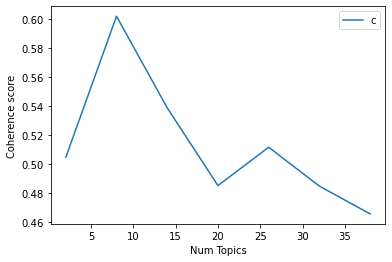

In [28]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [29]:
# Select the model and print the topics
optimal_model = ldamallet
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.036*"poder" + 0.035*"ser" + 0.026*"persona" + 0.021*"mejor" + '
  '0.019*"politico" + 0.014*"pensar" + 0.013*"dinero" + 0.012*"partido" + '
  '0.012*"deber" + 0.012*"existir"'),
 (1,
  '0.053*"police" + 0.042*"colombian" + 0.020*"amp" + 0.017*"protester" + '
  '0.016*"violence" + 0.016*"shoot" + 0.015*"protest" + 0.014*"stop" + '
  '0.012*"murder" + 0.011*"attack"'),
 (2,
  '0.086*"ver" + 0.051*"ir" + 0.050*"querer" + 0.041*"solo" + 0.038*"gente" + '
  '0.020*"acabar" + 0.017*"problema" + 0.016*"dejar" + 0.015*"si" + '
  '0.015*"volver"'),
 (3,
  '0.066*"people" + 0.035*"kill" + 0.034*"government" + 0.027*"protest" + '
  '0.018*"happen" + 0.015*"day" + 0.012*"live" + 0.011*"state" + 0.010*"world" '
  '+ 0.009*"today"'),
 (4,
  '0.075*"hacer" + 0.030*"poder" + 0.025*"hablar" + 0.022*"parte" + '
  '0.020*"entonce" + 0.018*"todo" + 0.018*"trabajar" + 0.017*"necesitar" + '
  '0.017*"gracia" + 0.017*"si"'),
 (5,
  '0.048*"duque" + 0.046*"vida" + 0.030*"calle" + 0.026*"dar" + 0.022

### Finding dominant topic in each sentence

In [30]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.1000,"poder, ser, persona, mejor, politico, pensar, ...",hacer mayo cazar fantasma
1,1,4.0,0.1273,"hacer, poder, hablar, parte, entonce, todo, tr...",despues esperar ancia ahora esperar despues se...
2,2,9.0,0.1356,"estar, paro, nacional, joven, vivo, vivir, des...",esperar llegar oido nuevo iniciar laboral part...
3,3,0.0,0.1287,"poder, ser, persona, mejor, politico, pensar, ...",menos mes urkullu temer perder control dar pas...
4,4,0.0,0.1133,"poder, ser, persona, mejor, politico, pensar, ...",edicion festival internacional puente hacia ce...
5,5,0.0,0.1000,"poder, ser, persona, mejor, politico, pensar, ...",cgt celebrar mayo hostigamiento sufrido empresa
6,6,4.0,0.1154,"hacer, poder, hablar, parte, entonce, todo, tr...",cgt celebrar acto central primero mayo
7,7,4.0,0.1176,"hacer, poder, hablar, parte, entonce, todo, tr...",conmemorar dia internacional trabajador ocasio...
8,8,0.0,0.1000,"poder, ser, persona, mejor, politico, pensar, ...",pasado puente san jose pasado semana santo abe...
9,9,9.0,0.1226,"estar, paro, nacional, joven, vivo, vivir, des...",pascua resurreccion domingo posterior primero ...


In [31]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.6361,"poder, ser, persona, mejor, politico, pensar, ...",pais sufrir grave crisis economico social azot...
1,1.0,0.3510,"police, colombian, amp, protester, violence, s...",u would interested topple chavista junta would...
2,2.0,0.4526,"ver, ir, querer, solo, gente, acabar, problema...",buen atravesado pecho hacer rato asi suponer m...
3,3.0,0.3553,"people, kill, government, protest, happen, day...",read previous post first national protest stri...
4,4.0,0.3115,"hacer, poder, hablar, parte, entonce, todo, tr...",llamar atencion usuario youperroamarillo respo...
5,5.0,0.2241,"duque, vida, calle, dar, favor, todo, matar, v...",pueblo matar pueblo matar pueblo matar pueblo ...
6,6.0,0.2743,"social, colombio, civil, idea, narco, total, e...",carrasquilla exministro hacendarenunce5er ayer...
7,7.0,0.7623,"country, tax, make, government, people, time, ...",come point sacrifice need make crisis perfect ...
8,8.0,0.2348,"gobierno, mas, pueblo, criminal, apoyar, corru...",realidad usar whipalo bandera identificar pueb...
9,9.0,0.3284,"estar, paro, nacional, joven, vivo, vivir, des...",? donde estar desaparecido paro nacional ? don...


In [32]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(20)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"poder, ser, persona, mejor, politico, pensar, ...",5840.0,0.2635
1.0,4.0,"hacer, poder, hablar, parte, entonce, todo, tr...",1735.0,0.0783
2.0,9.0,"estar, paro, nacional, joven, vivo, vivir, des...",2282.0,0.1030
3.0,0.0,"poder, ser, persona, mejor, politico, pensar, ...",1424.0,0.0643
4.0,0.0,"poder, ser, persona, mejor, politico, pensar, ...",2214.0,0.0999
5.0,0.0,"poder, ser, persona, mejor, politico, pensar, ...",2243.0,0.1012
6.0,4.0,"hacer, poder, hablar, parte, entonce, todo, tr...",1865.0,0.0842
7.0,4.0,"hacer, poder, hablar, parte, entonce, todo, tr...",954.0,0.0431
8.0,0.0,"poder, ser, persona, mejor, politico, pensar, ...",1796.0,0.0810
9.0,9.0,"estar, paro, nacional, joven, vivo, vivir, des...",1807.0,0.0815
